# Processing data from Mass-spectrometry experiments

In [169]:
import numpy as np
import pandas as pd

from copy import deepcopy

import matplotlib.pyplot as plt

import regseq2

regseq2.viz.matplotlib_style()

## Parse individual files

In this data we are looking for enrichment of transcription factors bound to the DNA oligos compared to control sequences. We first normalize the abundance of all proteins within a sample, and then compare the relative abundance of each protein in a sample compared to control. 

In [170]:
def parse_mass_spec(file, sample_dict, gc_dict):
    # some files are csv, some are excel
    if '.csv' in file:
        df = pd.read_csv(file)
    elif '.xlsx' in file:
        df = pd.read_excel(file)

    # get date of experiment
    date = file.split('/')[5].split('_')[0]

    # Get column headers
    cols = [x for x in df.columns if np.any([y == x[:3] for y in sample_dict.keys()])]
    df = deepcopy(df)

    # normalize each sample
    for col in cols:
        df[col] = df[col] / np.sum(df[col])
    
    # reshape dataframe
    df_parsed = pd.melt(df, id_vars=['Sum PEP Score', '# Peptides', 'Gene Symbol'], value_vars=cols, var_name='sample', value_name='abundance')
    
    # add condition and sample name
    sample = []
    gc = []
    for s in df_parsed['sample'].values:
        sample.append(sample_dict[s[:3]])
        gc.append(gc_dict[s[3:]])
    df_parsed['sample'] = sample
    df_parsed['condition'] = gc

    # split by conditions and compute enrichment
    out_df_list = []
    control_list = []
    for gc, gdf in df_parsed.groupby('condition'):
        gdf = pd.pivot(gdf, index=['Sum PEP Score', '# Peptides', 'Gene Symbol', 'condition'], columns='sample', values='abundance').reset_index()
        
        control_cols = [col for col in gdf.columns[4:] if 'Control' in col]
        filtered_cols = [col for col in gdf.columns[4:] if 'Control' not in col]
        
        for control in control_cols:
            _df = deepcopy(gdf)
            _df = _df[_df[control] > 0]
            for col in filtered_cols:
                _df[col] = _df[col] / _df[control]
                
            _df.drop(control_cols, axis=1, inplace=True)
            _df['Control'] = [key for key, val in sample_dict.items() if val == control][0]
            _df['date'] = date
            
            out_df_list.append(_df.dropna(subset='Gene Symbol').fillna(0))
            control_list.append((_df['Control'].values[0], _df['condition'].values[0]))
    return out_df_list, control_list

Now we go through each experiment, and compute enrichments. Then, all experiments get concatenated together for easier evaluation later. In each experiment, the samples are named by the DNA oligo used and the condition the cells used to make the lysate are grown in .

In [171]:
df_list = []
df = pd.read_csv("../../../data/mass-spec/20240905_salt_stat-phase/HJ_20240905_OTE_AurTS25_TMTpro_1.csv")

sample_dict = {
    "058": "Control",
    "208": "yjbJ",
    "210": "yadE",
    "212": "yadI",
    "214": "ybaY",
    "216": "yagB",
    "218": "yqjE"
}

gc_dict = {
    "S": 'stationary',
    "N": 'salt'
}
out_df_list, control_list = parse_mass_spec("../../../data/mass-spec/20240905_salt_stat-phase/HJ_20240905_OTE_AurTS25_TMTpro_1.csv", sample_dict, gc_dict)
print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('058', 'salt'), ('058', 'stationary')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,yadE,yadI,yagB,ybaY,yjbJ,yqjE,Control,date
1,0.667,1,norV,salt,1.337115,0.603475,1.198823,1.977088,0.895357,0.743588,058,20240905
2,0.669,1,bamB,salt,0.954172,1.028334,0.349491,0.912143,0.874587,0.681428,058,20240905
4,0.674,1,uvrC,salt,1.043993,1.252748,1.630782,1.308406,1.144466,1.007915,058,20240905
5,0.676,1,paaB,salt,1.161389,1.474776,2.134713,2.088479,1.208958,1.730728,058,20240905
6,0.687,1,ampH,salt,1.198578,1.047317,1.627733,1.260605,1.373734,0.880463,058,20240905


In [172]:
sample_dict = {
    "058": "Control",
    "208": "yjbJ",
    "210": "yadE",
    "212": "yadI",
    "214": "ybaY",
    "216": "yagB",
    "218": "yqjE"
}

gc_dict = {
    "SA": 'stationary, 37C',
    "NA": 'salt, 37C'
}

out_df_list, control_list = parse_mass_spec("../../../data/mass-spec/20240905_salt_stat-phase/HJ_20240905_OTE_AurTS25_TMTpro_2.csv", sample_dict, gc_dict)
print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('058', 'salt, 37C'), ('058', 'stationary, 37C')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,yadE,yadI,yagB,ybaY,yjbJ,yqjE,Control,date
0,0.857,1,dkgA,"salt, 37C",0.647869,0.806747,0.459999,0.826681,0.452815,0.491718,058,20240905
1,0.862,1,yfcS,"salt, 37C",1.314038,1.304962,0.861778,1.602645,0.771200,0.692148,058,20240905
2,0.885,1,coaBC,"salt, 37C",0.911062,1.123397,1.015582,1.719515,0.756684,0.849036,058,20240905
3,0.885,1,fucU,"salt, 37C",1.148481,1.318150,0.929154,1.226961,0.901481,1.075390,058,20240905
4,0.888,1,yeeJ,"salt, 37C",1.350603,1.625477,0.705539,1.266195,0.917889,0.680888,058,20240905


In [173]:
df = pd.read_excel("../../../data/mass-spec/20241031/HJ_20241031_OTE_AurTS25_sc90min_1.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '496C',
       '496G', '241G', '058C', '058G', '839G', '837G', '835G', '496CH', '496H',
       '241H', '058CH', '058H', '839H', '837H', '835H',
       'Found in Sample: [S225] F17: 126, Sample',
       'Found in Sample: [S227] F17: 127C, Sample',
       'Found in Sample: [S226] F17: 127N, Sample',
       'Found in Sample: [S229] F17: 128C, Sample',
       'Found in Sample: [S228] F17: 128N, Sample',
       'Found in Sample: [S231] F17: 

In [174]:
sample_dict = {
    "058": "Control",
    "496": "mglB_1",
    "241": "araB_2",
    "839": "Control_long",
    "837": "Control_medium",
    "835": "Control_short",
}

gc_dict = {
    "C": 'cAMP, 4C',
    "CH": 'cAMP, 37C',
    "H": 'glucose, 37C',
    "G": 'glucose, 4C'
}

out_df_list, control_list = parse_mass_spec("../../../data/mass-spec/20241031/HJ_20241031_OTE_AurTS25_sc90min_1.xlsx", sample_dict, gc_dict)
print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('058', 'cAMP, 37C'), ('058', 'cAMP, 4C'), ('058', 'glucose, 37C'), ('839', 'glucose, 37C'), ('837', 'glucose, 37C'), ('835', 'glucose, 37C'), ('058', 'glucose, 4C'), ('839', 'glucose, 4C'), ('837', 'glucose, 4C'), ('835', 'glucose, 4C')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,mglB_1,Control,date
0,0.945,1,yihL,"cAMP, 37C",0.886620,058,20241031
1,0.982,1,gph,"cAMP, 37C",1.097478,058,20241031
2,0.992,1,intA,"cAMP, 37C",1.252113,058,20241031
3,1.005,1,manA,"cAMP, 37C",1.112218,058,20241031
4,1.016,1,recC,"cAMP, 37C",1.146480,058,20241031


In [175]:
df = pd.read_excel("../../../data/mass-spec/20241031/HJ_20241031_OTE_AurTS25_sc90min_2.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '058N',
       '208N', '216N', '058S', '208S', '216S', '054G', '058G', '058NA',
       '208NA', '216NA', '058SA', '208SA', '216SA', '054GA', '058GA',
       'Found in Sample: [S243] F18: 126, Sample',
       'Found in Sample: [S245] F18: 127C, Sample',
       'Found in Sample: [S244] F18: 127N, Sample',
       'Found in Sample: [S247] F18: 128C, Sample',
       'Found in Sample: [S246] F18: 128N, Sample',
       'Found in Sample: [S249]

In [176]:
sample_dict = {
    "058": "Control",
    "054": "lacI_Oid",
    "208": "yjbJ",
    "216": "yagB",
}

gc_dict = {
    'S': 'stationary',
    'N': 'salt',
    'G': 'glucose',
    'SA': 'stationary, 37C',
    'NA': 'salt, 37C',
    'GA': 'glucose, 37C'
}

file = "../../../data/mass-spec/20241031/HJ_20241031_OTE_AurTS25_sc90min_2.xlsx"
out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)
print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('058', 'glucose'), ('058', 'glucose, 37C'), ('058', 'salt'), ('058', 'salt, 37C'), ('058', 'stationary'), ('058', 'stationary, 37C')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,lacI_Oid,Control,date
1,0.977,1,corC,glucose,1.800420,058,20241031
2,1.001,1,leuB,glucose,0.746314,058,20241031
3,1.032,1,gloA,glucose,0.964412,058,20241031
4,1.052,1,mdh,glucose,0.811423,058,20241031
5,1.056,1,uspE,glucose,1.043356,058,20241031


In [177]:
sample_dict = {
    "058": "Control",
    "054": "lacI_Oid",
    "208": "yjbJ",
    "216": "yagB",
}

gc_dict = {
    'S': 'stationary, 4C',
    'N': 'salt, 4C',
    'G': 'glucose, 4C',
    'SA': 'stationary, 37C',
    'NA': 'salt, 37C',
    'GA': 'glucose, 37C'
}

file = "../../../data/mass-spec/20241105/HJ_20241031_OTE_AurTS25_sc90min_2.xlsx"
out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)
print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('058', 'glucose, 37C'), ('058', 'glucose, 4C'), ('058', 'salt, 37C'), ('058', 'salt, 4C'), ('058', 'stationary, 37C'), ('058', 'stationary, 4C')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,lacI_Oid,Control,date
1,0.977,1,corC,"glucose, 37C",1.059888,058,20241105
2,1.001,1,leuB,"glucose, 37C",0.849838,058,20241105
3,1.032,1,gloA,"glucose, 37C",1.553941,058,20241105
4,1.052,1,mdh,"glucose, 37C",1.482270,058,20241105
5,1.056,1,uspE,"glucose, 37C",0.913251,058,20241105


In [178]:
df = pd.read_excel("../../../data/mass-spec/20241125/HJ_20241125_OTE_AurTS25_set1_proteins.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '208S',
       '212S', '216S', '233S', '829S', '835S', '837S', '839S', '174S', '176S',
       '178S', '180S', '186S', '188S', '192S', '196S',
       'Found in Sample: [S261] F19: 126, Sample',
       'Found in Sample: [S262] F19: 127N, Sample',
       'Found in Sample: [S263] F19: 127C, Sample',
       'Found in Sample: [S264] F19: 128N, Sample',
       'Found in Sample: [S265] F19: 128C, Sample',
       'Found in Sample: [S266] F19: 12

In [179]:
sample_dict = {
    "208": "yjbJ",
    "216": "yagB",
    '212': 'yadI',
    '233': 'gyrA',
    '829': 'acrZ',
    '835': 'Control',
    '837': 'Control_2',
    '839': 'Control_3',
    '174': 'mhpRp2',
    '176': 'ygiW_1',
    '178': 'ygiW_2',
    '180': 'sohA',
    '186': 'elaB',
    '188': 'rcsBp2',
    '192': 'galEp1',
    '196': 'tisB'
}

gc_dict = {
    'S': 'stationary',
}

file = "../../../data/mass-spec/20241125/HJ_20241125_OTE_AurTS25_set1_proteins.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)
print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('835', 'stationary'), ('837', 'stationary'), ('839', 'stationary')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,acrZ,elaB,galEp1,gyrA,mhpRp2,rcsBp2,sohA,tisB,yadI,yagB,ygiW_1,ygiW_2,yjbJ,Control,date
1,0.704,1,ybhR,stationary,1.926296,1.030832,1.023576,0.795138,1.166161,1.339130,1.122992,0.708967,1.083449,0.611859,1.005459,10.773220,1.440959,835,20241125
2,0.705,1,rplP,stationary,1.250113,0.928958,0.670643,1.229551,0.886647,0.797968,0.943984,0.841579,1.156676,0.834637,0.794670,1.093834,1.274766,835,20241125
4,0.713,1,ydcC,stationary,1.388916,1.486436,0.912751,2.283700,1.165679,1.134192,1.160907,1.734329,2.817193,1.111297,1.150434,1.399658,3.429108,835,20241125
6,0.728,1,fnr,stationary,1.413541,1.362518,0.820262,1.295073,1.549374,1.078757,1.175479,1.149622,1.380262,1.162002,0.998371,1.314059,1.640358,835,20241125
7,0.744,1,adiA,stationary,0.791320,0.588088,0.990957,0.690359,0.505569,0.595225,0.720869,3.375442,0.463795,0.365767,0.674847,0.505204,0.588079,835,20241125


In [180]:
df = pd.read_excel("../../../data/mass-spec/20241125/HJ_20241125_OTE_AurTS25_set2_proteins.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '837P',
       '975P', '977P', '979P', '981P', '983P', '985P', '837N1', '098N1',
       '985N1', '837N2', '208N2', '214N2', '216N2', '098N2', '985N2',
       'Found in Sample: [S279] F20: 126, Sample',
       'Found in Sample: [S280] F20: 127N, Sample',
       'Found in Sample: [S281] F20: 127C, Sample',
       'Found in Sample: [S282] F20: 128N, Sample',
       'Found in Sample: [S283] F20: 128C, Sample',
       'Found in Sample: [S284

In [181]:
sample_dict = {
    "975": "pheMp",
    "977": "furpb",
    '979': 'flda',
    '981': 'ihfAp',
    '983': 'ompRp3',
    '985': 'ecnb',
    '098': 'yqaE',
    '208': 'yjbJ',
    '214': 'ybaY',
    '216': 'yagB',
    '837': 'Control'
}

gc_dict = {
    'P': 'phenazine',
    'N1': 'salt',
    'N2': 'salt2'
}

file = "../../../data/mass-spec/20241125/HJ_20241125_OTE_AurTS25_set2_proteins.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'phenazine'), ('837', 'salt'), ('837', 'salt2')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,ecnb,flda,furpb,ihfAp,ompRp3,pheMp,Control,date
0,0.702,1,ispH,phenazine,0.420751,1.970115,1.371717,0.443603,1.249659,1.168800,837,20241125
2,0.715,1,ynfL,phenazine,0.661186,2.360458,1.594576,0.578972,1.587964,1.718929,837,20241125
3,0.721,1,leuC,phenazine,0.677650,2.390312,1.555270,0.642539,1.479206,1.388748,837,20241125
4,0.726,1,ymfD,phenazine,1.888540,1.810439,1.526497,1.435041,1.473193,1.331351,837,20241125
6,0.736,1,argG,phenazine,0.660935,1.373187,2.688696,0.657279,1.572246,0.870212,837,20241125


In [182]:
df = pd.read_excel("../../../data/mass-spec/20241216/HJ_20241216_OTE_AurTS25_setR.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '098S',
       '174S', '176S', '178S', '180S', '182S', '186S', '188S', '190S', '192S',
       '194S', '196S', '233S', '829S', '837S', '839S',
       'Found in Sample: [S298] F22: 126, Sample',
       'Found in Sample: [S316] F22: 127N, Sample',
       'Found in Sample: [S317] F22: 127C, Sample',
       'Found in Sample: [S318] F22: 128N, Sample',
       'Found in Sample: [S319] F22: 128C, Sample',
       'Found in Sample: [S320] F22: 12

In [183]:
sample_dict = {
    "098": "yqaE",
    "174": "mhpRp2",
    '176': 'ygiW_1',
    '178': 'ygiW_2',
    '180': 'sohA',
    '182': 'kbpp4',
    '186': 'elaB',
    '188': 'rcsBp2',
    '190': 'flda',
    '192': 'galEp1',
    '194': 'ompRp3',
    '196': 'tisB',
    '233': 'gyrA',
    '829': 'acrZ',
    '837': 'Control',
    '839': 'Control2'
}

gc_dict = {
    'S': 'stationary',
}

file = "../../../data/mass-spec/20241216/HJ_20241216_OTE_AurTS25_setR.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'stationary'), ('839', 'stationary')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,acrZ,elaB,flda,galEp1,gyrA,kbpp4,mhpRp2,ompRp3,rcsBp2,sohA,tisB,ygiW_1,ygiW_2,yqaE,Control,date
0,0.911,1,norW,stationary,1.316680,0.681443,1.272515,1.647433,0.747726,2.237095,1.928450,1.087173,1.180665,2.238188,0.549148,1.006547,1.062889,1.555550,837,20241216
1,0.920,1,trpR,stationary,1.267810,0.959285,1.010297,0.830112,1.026007,0.925707,0.800740,0.879506,0.820275,0.844536,0.721608,0.916456,0.988593,0.811316,837,20241216
2,0.924,1,surA,stationary,1.037301,0.896630,1.025973,0.677026,0.900269,0.884085,0.733003,0.670829,0.678053,0.832895,0.749327,0.768103,0.770285,0.720641,837,20241216
4,0.933,1,dsbD,stationary,0.752047,1.503037,0.770077,1.854238,1.384005,0.936631,1.186415,1.367952,1.232351,1.391548,1.667145,0.663111,0.643454,1.396339,837,20241216
5,0.952,1,yhaL,stationary,0.454218,0.578086,0.403710,0.300847,0.616674,0.360849,0.423177,0.347223,0.288028,0.350875,0.562299,0.290801,0.288333,0.443426,837,20241216


In [184]:
df = pd.read_excel("../../../data/mass-spec/20241216/HJ_20241216_OTE_AurTS25_setB.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '975P',
       '977P', '979P', '981P', '983P', '985P', '837P', '192D', '829D', '831D',
       '833D', '837D', '839D', '841D', '843D', '851D',
       'Found in Sample: [S297] F21: 126, Sample',
       'Found in Sample: [S299] F21: 127N, Sample',
       'Found in Sample: [S300] F21: 127C, Sample',
       'Found in Sample: [S301] F21: 128N, Sample',
       'Found in Sample: [S302] F21: 128C, Sample',
       'Found in Sample: [S303] F21: 12

In [185]:
sample_dict = {
    "975": "yqaE",
    "977": "furpb",
    '979': 'flda',
    '981': 'ihfAp',
    '983': 'ompRp3',
    '985': 'ecnb',
    '829': 'acrZ',
    '831': 'acrZ_2',
    '833': 'marRp',
    '841': 'dicCp',
    '843': 'yqjE_2',
    '851': 'galEp1',
    '192': 'gyrA',
    '829': 'acrZ',
    '837': 'Control_medium',
    '839': 'Control_short'
}


gc_dict = {
    'P': 'phenazine',
    'D': 'dipyridyl',
}

file = "../../../data/mass-spec/20241216/HJ_20241216_OTE_AurTS25_setB.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'dipyridyl'), ('839', 'dipyridyl'), ('837', 'phenazine')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,acrZ,acrZ_2,dicCp,galEp1,gyrA,marRp,yqjE_2,Control,date
0,0.786,1,yciX,dipyridyl,1.512084,1.264988,0.932717,1.841354,5.193230,0.906386,1.212574,837,20241216
2,0.788,1,wzzB,dipyridyl,1.615129,1.587534,1.126434,1.563038,1.123154,1.439338,1.675628,837,20241216
3,0.820,1,dgcP,dipyridyl,0.628996,1.577660,0.450040,0.507812,0.376841,0.706812,0.979685,837,20241216
4,0.825,1,sufD,dipyridyl,0.649976,1.143590,0.996412,0.905617,0.850558,0.872840,1.489553,837,20241216
5,0.832,1,proB,dipyridyl,1.246799,1.239976,1.121574,1.309054,0.939731,1.382404,1.127836,837,20241216


In [186]:
df = pd.read_excel("../../../data/mass-spec/20241221/HJ_20241221_OTE_AurTS25_setR.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '231A',
       '233A', '481A', '839A', '192D', '829D', '831D', '833D', '839D', '841D',
       '843D', '851D', '182X', '839X', '849X', '853X',
       'Found in Sample: [S370] F26: 126, Sample',
       'Found in Sample: [S388] F26: 127N, Sample',
       'Found in Sample: [S389] F26: 127C, Sample',
       'Found in Sample: [S390] F26: 128N, Sample',
       'Found in Sample: [S391] F26: 128C, Sample',
       'Found in Sample: [S392] F26: 12

In [187]:
sample_dict = {
    "231": "yahC",
    "233": "gyrA",
    '839': 'Control',
    '192': 'galEp1',
    '481': 'rcsBp2',
    '829': 'acrZ',
    '831': 'acrZ_2',
    '833': 'marRp',
    '841': 'dicCp',
    '843': 'aceBp',
    '851': 'yqjE_2',
    '182': 'kbpp4',
    '849': 'rcsDp',
    '853': 'araCp'
}


gc_dict = {
    'A': 'arabinose',
    'D': 'dipyridyl',
    'X': 'xylose',
    
}

file = "../../../data/mass-spec/20241221/HJ_20241221_OTE_AurTS25_setR.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('839', 'arabinose'), ('839', 'dipyridyl'), ('839', 'xylose')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,gyrA,rcsBp2,yahC,Control,date
0,0.889,1,thrB,arabinose,1.631692,0.741472,0.354672,839,20241221
1,0.895,1,infC,arabinose,0.533457,0.726065,1.221724,839,20241221
2,0.955,1,purF,arabinose,0.996238,0.418939,0.307304,839,20241221
3,0.956,1,cusS,arabinose,1.493464,0.752647,0.748111,839,20241221
4,0.959,1,glgS,arabinose,0.629279,0.601210,0.187021,839,20241221


In [188]:
df = pd.read_excel("../../../data/mass-spec/20241221/HJ_20241221_OTE_AurTS25_setB.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '235A',
       '237A', '239A', '241A', '484A', '489A', '492A', '496A', '498A', '500A',
       '839A', '186G', '214G', '837G', '855G', '981G',
       'Found in Sample: [S369] F25: 126, Sample',
       'Found in Sample: [S371] F25: 127N, Sample',
       'Found in Sample: [S372] F25: 127C, Sample',
       'Found in Sample: [S373] F25: 128N, Sample',
       'Found in Sample: [S374] F25: 128C, Sample',
       'Found in Sample: [S375] F25: 12

In [189]:
sample_dict = {
    "235": "TSS_1414_1",
    "237": "TSS_1414_2",
    '239': 'araB_1',
    '241': 'araB_2',
    '484': 'tmaR_1',
    '489': 'tmaR_2',
    '496': 'mglB_1',
    '492': 'tmaR_3',
    '498': 'rspA_1',
    '500': 'rspA_2',
    '186': 'elaB',
    '214': 'ybaY',
    '855': 'mglB_2',
    '837': 'Control_medium',
    '839': 'Control_long',
    '981': 'ihfAp'
}


gc_dict = {
    'A': 'arabinose',
    'G': 'glucose',
    'D': 'dipyridyl',
    'X': 'Xylose'
}

file = "../../../data/mass-spec/20241221/HJ_20241221_OTE_AurTS25_setB.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('839', 'arabinose'), ('837', 'glucose')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,TSS_1414_1,TSS_1414_2,araB_1,araB_2,mglB_1,rspA_1,rspA_2,tmaR_1,tmaR_2,tmaR_3,Control,date
0,0.893,1,fliJ,arabinose,0.788823,0.580309,0.397554,1.290206,0.504285,0.477320,1.493587,0.750334,0.250900,0.619301,839,20241221
1,0.897,1,rsmB,arabinose,0.801821,0.546104,0.614557,0.741948,0.743646,0.692434,0.611287,0.763965,0.529733,0.720850,839,20241221
2,0.910,1,coaA,arabinose,1.098031,0.837686,0.764267,0.967240,0.920609,0.935451,0.901920,0.954956,0.542322,0.983650,839,20241221
3,0.915,1,leuA,arabinose,0.996133,0.612568,0.633428,0.864578,0.756081,0.810606,0.803751,0.846547,0.268689,0.686371,839,20241221
5,0.973,1,atpE,arabinose,1.097126,1.057475,0.411151,0.748893,0.980539,0.719754,0.820525,0.859389,0.206021,0.539652,839,20241221


In [190]:
df = pd.read_excel("../../../data/mass-spec/20250113_analysis/HJ_20250112_OTE_AurTS25_setR.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '738J',
       '740J', '742J', '744J', '746J', '748J', '839J', '186G', '214G', '837G',
       '855G', '981G', '182X', '839X', '849X', '853X',
       'Found in Sample: [S406] F28: 126, Sample',
       'Found in Sample: [S424] F28: 127N, Sample',
       'Found in Sample: [S425] F28: 127C, Sample',
       'Found in Sample: [S426] F28: 128N, Sample',
       'Found in Sample: [S427] F28: 128C, Sample',
       'Found in Sample: [S428] F28: 12

In [191]:
sample_dict = {
    '738': 'cpxR',
    "740": "intE",
    "742": "yadE2",
    '744': 'ybeDp',
    '746': 'ompRp2',
    '748': 'acrA',
    '839': 'Control_long',
    '186': 'elaB',
    '214': 'ybaY',
    '837': 'Control_medium',
    '855': 'mglB_2',
    '981': 'ihfAp',
    '182': 'kbpp4',
    '839': 'Control_long',
    '849': 'rcsDp',
    '853': 'araCp',
}


gc_dict = {
    'J': 'gentamicin',
    'G': 'glucose',
    'X': 'Xylose'
}

file = "../../../data/mass-spec/20250113_analysis/HJ_20250112_OTE_AurTS25_setR.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('839', 'Xylose'), ('839', 'gentamicin'), ('837', 'glucose')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,araCp,kbpp4,rcsDp,Control,date
0,0.824,1,msbA,Xylose,0.879822,0.917583,0.962136,839,20250113
1,0.843,1,bcp,Xylose,0.664953,0.832080,1.159247,839,20250113
2,0.845,1,rsgA,Xylose,3.243423,0.549858,0.603054,839,20250113
3,0.849,1,yhcN,Xylose,0.938077,0.693058,0.895952,839,20250113
5,0.854,1,mukF,Xylose,0.522247,0.866596,1.057436,839,20250113


In [192]:
df = pd.read_excel("../../../data/mass-spec/20250113_analysis/HJ_20250112_OTE_AurTS25_setB.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '231A',
       '233A', '235A', '237A', '239A', '241A', '481A', '484A', '489A', '492A',
       '496A', '498A', '500A', '839A', '208S', '837S',
       'Found in Sample: [S405] F27: 126, Sample',
       'Found in Sample: [S407] F27: 127N, Sample',
       'Found in Sample: [S408] F27: 127C, Sample',
       'Found in Sample: [S409] F27: 128N, Sample',
       'Found in Sample: [S410] F27: 128C, Sample',
       'Found in Sample: [S411] F27: 12

In [193]:
sample_dict = {
    '231': 'yahC',
    "233": "gyrA",
    "235": "TSS_1414_1",
    '237': 'TSS_1414_2',
    '239': 'araB_1',
    '241': 'araB_2',
    '481': 'rcsBp2',
    '484': 'tmaR_1',
    '489': 'tmaR_2',
    '492': 'tmaR_3',
    '496': 'mglB_1',
    '498': 'rspA_1',
    '500': 'rspA_2',
    '839': 'Control_long',
    '837': 'Control_medium',
    '208': 'yjbJ'
}


gc_dict = {
    'S': 'stationary',
    'A': 'arabinose',
}

file = "../../../data/mass-spec/20250113_analysis/HJ_20250112_OTE_AurTS25_setB.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('839', 'arabinose'), ('837', 'stationary')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,TSS_1414_1,TSS_1414_2,araB_1,araB_2,gyrA,mglB_1,rcsBp2,rspA_1,rspA_2,tmaR_1,tmaR_2,tmaR_3,yahC,Control,date
0,0.768,1,hofO,arabinose,1.308145,1.526434,1.000012,2.336084,0.465551,6.369113,2.105414,1.163811,1.641571,1.649926,1.597178,1.756839,0.488055,839,20250113
2,0.790,1,yafC,arabinose,0.982845,0.681712,0.619041,0.665986,0.221118,0.792834,0.790149,0.985623,1.050881,0.631255,0.521170,0.870506,0.369484,839,20250113
3,0.798,1,frmB,arabinose,1.421125,0.774491,0.754823,1.101900,0.233028,1.202157,0.950326,0.768570,1.129668,0.805793,0.645407,1.054173,0.431177,839,20250113
4,0.799,1,norV,arabinose,2.290059,2.843075,1.773900,0.863506,4.902626,2.504637,1.184075,1.154494,1.077868,0.792076,1.473089,1.734641,1.149344,839,20250113
6,0.816,1,ychA,arabinose,1.554991,1.015837,0.991658,0.847218,0.216243,1.105474,0.960795,0.961867,1.310198,0.773011,0.737198,1.073679,0.498006,839,20250113


In [194]:
df = pd.read_excel("../../../data/mass-spec/20250124_analysis/HJ_20250122_OTE_AurTS25_setB.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '738J',
       '740J', '742J', '744J', '746J', '748J', '839J', '975P', '977P', '979P',
       '981P', '983P', '985P', '839P', '212S', '839S',
       'Found in Sample: [S441] F29: 126, Sample',
       'Found in Sample: [S443] F29: 127N, Sample',
       'Found in Sample: [S444] F29: 127C, Sample',
       'Found in Sample: [S445] F29: 128N, Sample',
       'Found in Sample: [S446] F29: 128C, Sample',
       'Found in Sample: [S447] F29: 12

In [195]:
sample_dict = {
    '738': 'cpxR',
    "740": "intE",
    "742": "yadE2",
    '744': 'ybeDp',
    '746': 'ompRp2',
    '748': 'acrA',
    '839': 'Control_long',
    '975': 'elaB',
    '977': 'furpb',
    '979': 'flda',
    '981': 'ihfAp',
    '983': 'ompRp3',
    '985': 'ecnb',
    '839': 'Control_long',
    '212': 'yadI',
}


gc_dict = {
    'S': 'stationary',
    'J': 'gentamicin',
    'P': 'phenazine'
}

file = "../../../data/mass-spec/20250124_analysis/HJ_20250122_OTE_AurTS25_setB.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('839', 'gentamicin'), ('839', 'phenazine'), ('839', 'stationary')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,acrA,cpxR,intE,ompRp2,yadE2,ybeDp,Control,date
4,0.788,1,tktA,gentamicin,0.409415,1.454584,0.774908,0.563699,0.901669,0.509385,839,20250124
8,0.809,1,gmk,gentamicin,0.825368,1.546160,1.224927,0.772202,1.152430,0.866254,839,20250124
9,0.811,1,efeO,gentamicin,0.941927,1.296091,1.328142,1.149461,1.435018,0.847154,839,20250124
10,0.812,1,sodA,gentamicin,0.280900,1.480930,0.407378,0.829881,0.467087,0.320772,839,20250124
11,0.814,1,frmB,gentamicin,0.511624,2.821971,1.239974,0.685529,1.141037,0.445629,839,20250124


In [196]:
df = pd.read_excel("../../../data/mass-spec/20250124_analysis/HJ_20250122_OTE_AurTS25_setR.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '875G',
       '878G', '882G', '885G', '889G', '892G', '895G', '898G', '905G', '083G',
       '085G', '837G', '893G', '087S', '089S', '837S',
       'Found in Sample: [S442] F30: 126, Sample',
       'Found in Sample: [S460] F30: 127N, Sample',
       'Found in Sample: [S461] F30: 127C, Sample',
       'Found in Sample: [S462] F30: 128N, Sample',
       'Found in Sample: [S463] F30: 128C, Sample',
       'Found in Sample: [S464] F30: 12

In [197]:
sample_dict = {
    '875': 'uofp',
    "878": "lpp1",
    "882": "lpp2",
    '885': 'blr',
    '889': 'ybiY1',
    '892': 'ybiY2',
    '895': 'ybiY3',
    '898': 'araCp_2',
    '905': 'zapB1',
    '083': 'zapB2',
    '085': 'zapB3',
    '837': 'Control_medium',
    '839': 'Control_long',
    '087': 'ompRp2',
    '089': 'acrA',
}


gc_dict = {
    'G': 'glucose',
    'S': 'stationary',
}

file = "../../../data/mass-spec/20250124_analysis/HJ_20250122_OTE_AurTS25_setR.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'glucose'), ('837', 'stationary')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,araCp_2,blr,lpp1,lpp2,uofp,ybiY1,ybiY2,ybiY3,zapB1,zapB2,zapB3,Control,date
0,0.723,1,yciH,glucose,1.087945,1.132266,0.777860,1.688388,0.952203,0.847351,0.958291,0.957114,0.994442,0.883050,1.356597,837,20250124
1,0.729,1,rpsR,glucose,0.735674,0.979305,1.319458,0.658870,1.010451,0.561976,0.890785,0.858243,0.898801,1.246372,0.728843,837,20250124
2,0.736,1,glgC,glucose,1.178218,1.041815,0.800652,1.153409,0.897874,1.602547,0.878652,0.975126,0.969341,1.168908,0.984162,837,20250124
5,0.757,1,waaY,glucose,0.683231,0.760432,0.516711,0.979852,0.628727,0.642156,0.699372,0.798471,0.828153,0.636076,0.861841,837,20250124
7,0.806,1,yhiL,glucose,1.126763,1.137958,1.254438,1.357985,1.222563,0.965354,1.141499,1.193773,1.778366,1.021924,0.914313,837,20250124


In [198]:
df = pd.read_excel("../../../data/mass-spec/20250213_analysis/HJ_20250210_OTE_AurTS25_setB.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '853X',
       '849X', '839X', '182X', '837S', '218S', '214S', '212S', '210S', '208S',
       '837N', '210N', '214N', '212N', '208N', '098N',
       'Found in Sample: [S477] F31: 126, Sample',
       'Found in Sample: [S479] F31: 127N, Sample',
       'Found in Sample: [S480] F31: 127C, Sample',
       'Found in Sample: [S481] F31: 128N, Sample',
       'Found in Sample: [S482] F31: 128C, Sample',
       'Found in Sample: [S483] F31: 12

In [199]:
sample_dict = {
    '853': 'araCp',
    "849": "rcsDp",
    "839": "Control_long",
    '182': 'kbpp4',
    '837': 'Control_medium',
    '218': 'yqjE',
    '214': 'ybaY',
    '212': 'yadI',
    '210': 'yadE',
    '208': 'yjbJ',
    '098': 'yqaE',
}


gc_dict = {
    'X': 'xylose',
    'S': 'stationary',
    'N': 'salt'
}

file = "../../../data/mass-spec/20250213_analysis/HJ_20250210_OTE_AurTS25_setB.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'salt'), ('837', 'stationary'), ('839', 'xylose')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,yadE,yadI,ybaY,yjbJ,yqaE,Control,date
0,0.739,1,rhsD,salt,0.252366,0.883132,1.623022,0.839576,0.834788,837,20250213
1,0.744,1,mutL,salt,0.521331,0.757295,0.651412,0.700765,1.109054,837,20250213
2,0.760,1,ycgM,salt,0.388302,0.723857,0.814457,0.762704,0.845154,837,20250213
3,0.762,1,proS,salt,1.045921,0.936234,0.906010,0.946648,1.039943,837,20250213
4,0.774,1,rpsG,salt,1.779912,1.093493,1.249677,1.165773,1.389783,837,20250213


In [200]:
df = pd.read_excel("../../../data/mass-spec/20250213_analysis/HJ_20250210_OTE_AurTS25_setR.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '839G',
       '981G', '905G', '898G', '895G', '892G', '889G', '885G', '888G', '878G',
       '875G', '855G', '214G', '186G', '085G', '083G',
       'Found in Sample: [S478] F32: 126, Sample',
       'Found in Sample: [S496] F32: 127N, Sample',
       'Found in Sample: [S497] F32: 127C, Sample',
       'Found in Sample: [S498] F32: 128N, Sample',
       'Found in Sample: [S499] F32: 128C, Sample',
       'Found in Sample: [S500] F32: 12

In [201]:
sample_dict = {
    '905': 'zapB1',
    "981": "ihfAp",
    "839": "Control_long",
    '898': 'araCp_2',
    '895': 'ybiY3',
    '892': 'ybiY2',
    '889': 'ybiY1',
    '885': 'blr',
    '882': 'lpp2',
    '878': 'lpp1',
    '875': 'uofp',
    '855': 'mglB_2',
    '214': 'ybaY',
    '186': 'elaB',
    '085': 'zapB3',
    '083': 'zapB2'
}


gc_dict = {
    'G': 'glucose',
    'X': 'xylose'
}

file = "../../../data/mass-spec/20250213_analysis/HJ_20250210_OTE_AurTS25_setR.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('839', 'glucose')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,araCp_2,blr,elaB,ihfAp,lpp1,mglB_2,uofp,ybaY,ybiY1,ybiY2,ybiY3,zapB1,zapB2,zapB3,Control,date
2,0.820,1,ftsK,glucose,3.420193,2.804644,2.474087,2.600134,2.944851,1.948633,3.255254,3.147926,2.312953,3.280453,2.807136,3.127582,2.541482,2.583236,839,20250213
4,0.854,1,qmcA,glucose,0.437880,0.353878,0.480114,0.489737,0.526355,0.595054,0.463094,0.359443,0.459994,0.431738,0.618316,0.579967,0.480053,0.467464,839,20250213
5,0.859,1,acrA,glucose,0.248349,0.414543,0.511582,0.291596,0.369241,0.554222,0.326727,0.402525,0.384973,0.288640,0.313225,0.210324,0.406350,0.437225,839,20250213
6,0.861,1,yjiA,glucose,1.633433,1.701150,1.546565,1.468768,1.583969,1.481891,1.579455,1.588070,1.424537,1.610801,1.631642,1.472283,1.762430,1.858685,839,20250213
7,0.863,1,yheO,glucose,1.066978,0.829802,1.168245,1.043297,0.991722,2.620541,1.057348,0.851984,0.949197,0.728524,1.074952,1.086273,1.138556,1.075927,839,20250213


In [202]:
df = pd.read_excel("../../../data/mass-spec/20250303_analysis/HJ_20250303_OTE_AurTS25_set1.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '851D',
       '843D', '841D', '839D', '833D', '831D', '829D', '192D', '985P', '983P',
       '981P', '979P', '977P', '975P', '839P', '837P',
       'Found in Sample: [S549] F35: 126, Sample',
       'Found in Sample: [S551] F35: 127N, Sample',
       'Found in Sample: [S552] F35: 127C, Sample',
       'Found in Sample: [S553] F35: 128N, Sample',
       'Found in Sample: [S554] F35: 128C, Sample',
       'Found in Sample: [S555] F35: 12

In [203]:
sample_dict = {
    '851': 'yqjE_2',
    "843": "aceBp",
    "841": "dicCp",
    '839': 'Control_long',
    '833': 'marRp',
    '831': 'acrZ_2',
    '829': 'acrZ',
    '192': 'galEp1',
    '985': 'ecnb',
    '983': 'ompRp3',
    '981': 'ihfAp',
    '979': 'flda',
    '977': 'furpb',
    '975': 'pheMp',
    '837': 'Control_medium',
}


gc_dict = {
    'D': 'dipyridyl',
    'P': 'phenazine'
}

file = "../../../data/mass-spec/20250303_analysis/HJ_20250303_OTE_AurTS25_set1.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('839', 'dipyridyl'), ('839', 'phenazine'), ('837', 'phenazine')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,aceBp,acrZ,acrZ_2,dicCp,galEp1,marRp,yqjE_2,Control,date
0,0.816,1,aroA,dipyridyl,0.772941,0.749851,0.533904,0.833400,0.686652,0.543288,0.700047,839,20250303
1,0.832,1,usg,dipyridyl,1.079742,1.374930,1.710269,1.031153,0.800553,1.050089,0.965473,839,20250303
2,0.833,1,ivy,dipyridyl,0.643856,0.650565,0.525113,0.720149,0.612787,0.512858,0.822969,839,20250303
3,0.838,1,cyoB,dipyridyl,1.033824,0.938649,0.893645,0.986591,0.648758,0.807220,0.872551,839,20250303
4,0.847,1,dtpA,dipyridyl,0.938031,1.243811,1.040141,1.572856,0.588818,1.699929,0.811226,839,20250303


In [204]:
df = pd.read_excel("../../../data/mass-spec/20250303_analysis/HJ_20250303_OTE_AurTS25_set2.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '188$',
       '186$', '182$', '176$', '174$', '098$', '089$', '087$', '837N', '218N',
       '214N', '210N', '837$', '839$', '194$', '190$',
       'Found in Sample: [S550] F36: 126, Sample',
       'Found in Sample: [S568] F36: 127N, Sample',
       'Found in Sample: [S569] F36: 127C, Sample',
       'Found in Sample: [S570] F36: 128N, Sample',
       'Found in Sample: [S571] F36: 128C, Sample',
       'Found in Sample: [S572] F36: 12

In [205]:
sample_dict = {
    '188': 'rcsBp2',
    "186": "elaB",
    "176": "ygiW_1",
    '174': 'mhpRp2',
    '098': 'yqaE',
    '089': 'acrA',
    '087': 'ompRp2',
    '837': 'Control_medium',
    '218': 'yqjE',
    '214': 'ybaY',
    '210': 'yadE',
    '839': 'Control_long',
    '194': 'ompRp3',
    '190': 'fldA',
}


gc_dict = {
    '$': 'stationary, high vol',
    'N': 'salt'
}

file = "../../../data/mass-spec/20250303_analysis/HJ_20250303_OTE_AurTS25_set2.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'salt'), ('839', 'stationary, high vol'), ('837', 'stationary, high vol')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,yadE,ybaY,yqjE,Control,date
0,0.819,1,trpA,salt,0.756288,1.249102,0.704072,837,20250303
2,0.831,1,yibL,salt,1.608012,2.197494,1.098042,837,20250303
3,0.836,1,aroL,salt,0.343629,0.323368,0.591148,837,20250303
4,0.844,1,trxC,salt,1.299431,1.269853,0.505469,837,20250303
5,0.849,1,lpoA,salt,0.569038,0.807930,0.707716,837,20250303


In [206]:
df = pd.read_excel("../../../data/mass-spec/20250307/HJ_20250325_OTE_AurTS25_0307.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '839C2',
       '738C2', '655C2', '653C2', '839C1', '738C1', '655C1', '653C1', '837P',
       '196P', '186P', '985L', '837L', '839H', '651H', '216H',
       'Found in Sample: [S586] F38: 126, Sample',
       'Found in Sample: [S604] F38: 127N, Sample',
       'Found in Sample: [S605] F38: 127C, Sample',
       'Found in Sample: [S606] F38: 128N, Sample',
       'Found in Sample: [S607] F38: 128C, Sample',
       'Found in Sample: [S608]

In [207]:
sample_dict = {
    '839': 'Control_long',
    "738": "cpxR",
    "655": "cusC2",
    '653': 'cusC',
    '837': 'Control_medium',
    '196': 'tisB',
    '186': 'elaB',
    '985': 'ecnb',
    '651': 'yagB2',
    '216': 'yagB',
}


gc_dict = {
    'P': 'H2O2',
    'H': 'heatshock',
    'C1': 'copper1',
    'C2': 'copper2',
    'L': 'Leucine'
}

file = "../../../data/mass-spec/20250307/HJ_20250325_OTE_AurTS25_0307.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'H2O2'), ('837', 'Leucine'), ('839', 'copper1'), ('839', 'copper2'), ('839', 'heatshock')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,elaB,tisB,Control,date
0,0.859,1,glpQ,H2O2,0.723982,0.842354,837,20250307
1,0.861,1,ykgE,H2O2,1.099493,0.853349,837,20250307
3,0.873,1,yihF,H2O2,0.898234,0.858271,837,20250307
4,0.876,1,hemB,H2O2,0.785612,0.692563,837,20250307
6,0.886,1,ubiI,H2O2,0.970158,0.987582,837,20250307


In [208]:
df = pd.read_excel("../../../data/mass-spec/20250326/HJ_20250325_OTE_AurTS25_0313.xlsx")
df.columns

Index(['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession',
       'Description', 'Exp. q-value: Combined', 'Sum PEP Score',
       'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# AAs',
       'MW [kDa]', 'calc. pI', 'Score Sequest HT: Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', 'Biological Process',
       'Cellular Component', 'Molecular Function', 'Pfam IDs',
       'Entrez Gene ID', 'Ensembl Gene ID', 'Gene Symbol', 'Gene ID',
       'WikiPathways', '# Protein Pathway Groups', '# Razor Peptides', '985Le',
       '837Le', '837LB2', '657LB2', '212LB2', '837LB1', '657LB1', '212LB1',
       '837P', '196P', '186P', '839H', '651H', '216H',
       'Found in Sample: [S585] F37: 126, Sample',
       'Found in Sample: [S587] F37: 127N, Sample',
       'Found in Sample: [S588] F37: 127C, Sample',
       'Found in Sample: [S589] F37: 128N, Sample',
       'Found in Sample: [S590] F37: 128C, Sample',
       'Found in Sample: [S591] F37: 129N

In [209]:
sample_dict = {
    '839': 'Control_long',
    "738": "cpxR",
    "657": "icdC",
    '212': 'yadI',
    '837': 'Control_medium',
    '196': 'tisB',
    '186': 'elaB',
    '985': 'ecnb',
    '651': 'yagB2',
    '216': 'yagB',
}


gc_dict = {
    'P': 'H2O2',
    'H': 'heatshock',
    'LB1': 'LB1',
    'LB2': 'LB2',
    'Le': 'Leucine'
}

file = "../../../data/mass-spec/20250326/HJ_20250325_OTE_AurTS25_0313.xlsx"

out_df_list, control_list = parse_mass_spec(file, sample_dict, gc_dict)

print(control_list)
display(out_df_list[0].head(5))
df_list.extend(out_df_list)

[('837', 'H2O2'), ('837', 'LB1'), ('837', 'LB2'), ('837', 'Leucine'), ('839', 'heatshock')]


sample,Sum PEP Score,# Peptides,Gene Symbol,condition,elaB,tisB,Control,date
0,0.703,1,yedA,H2O2,0.893398,0.216459,837,20250326
2,0.715,1,clpA,H2O2,0.765301,1.118983,837,20250326
3,0.724,1,yeiQ,H2O2,0.308541,0.271059,837,20250326
4,0.728,1,gatY,H2O2,0.864040,0.626769,837,20250326
5,0.733,1,pfkB,H2O2,0.673172,0.811476,837,20250326


## Combine all the data sets

Now we can combine all datasets into a single dataframe.

In [210]:
df_combined = pd.concat([pd.melt(df, id_vars=['Sum PEP Score', '# Peptides', 'Gene Symbol', 'condition', 'Control', 'date'], value_name='enrichment') for df in df_list])

In [211]:
df_combined.reset_index(drop=True)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
0,0.667,1,norV,salt,058,20240905,yadE,1.337115
1,0.669,1,bamB,salt,058,20240905,yadE,0.954172
2,0.674,1,uvrC,salt,058,20240905,yadE,1.043993
3,0.676,1,paaB,salt,058,20240905,yadE,1.161389
4,0.687,1,ampH,salt,058,20240905,yadE,1.198578
...,...,...,...,...,...,...,...,...
196064,98.830,26,rpsA,heatshock,839,20250326,yagB2,1.899262
196065,101.665,24,rng,heatshock,839,20250326,yagB2,1.426218
196066,130.111,35,rpoC,heatshock,839,20250326,yagB2,0.691706
196067,136.401,29,prs,heatshock,839,20250326,yagB2,4.826310


## Filter for DNA binding proteins

In some samples we find enrichment for proteins that are not DNA binding proteins. We use RegulonDB to get a list of all transcription factors.

In [212]:
from bson import decode_all

with open("../../../data/metadata/regulonDatamart.bson", "rb") as file:
    data = file.read()

# Decode all BSON documents into a list of dictionaries
documents = decode_all(data)
len(documents)
df = pd.DataFrame(documents)

name_list = []
syn_list = [] 
type_list = []

for x in df['regulator'].values:
    name_list.append(x['abbreviatedName'])
    if 'synonyms' in x.keys():
        syn_list.append(x['synonyms'])
    else:
        syn_list.append([''])
    type_list.append(x['type'])

df_TF = pd.DataFrame({"name": name_list, 'synonyms':syn_list, 'type': type_list})

## Plot specific samples

Using the dataframe, we can make enrichment plots for specific examples shown in the paper.

In [230]:
def plot_mass_spec(df, sample, filter_binding_proteins=False, highlighted_genes=[], filter_control=None, yscale="log", sharey=True):
    
    df_filtered = df[df['sample'] == sample]

    
    if filter_binding_proteins:
        # Create a set of lowercased binding protein names from df_TF
        binding_names = set(df_TF['name'].str.lower())
        binding_names |= {syn.lower() for synonyms in df_TF['synonyms'] for syn in synonyms}
        
        # Filter df_filtered by checking if the lower-case gene symbol is in the set
        df_filtered = df_filtered[df_filtered['Gene Symbol'].str.lower().isin(binding_names)]

    if filter_control != None:
        if type(filter_control) == str:
            df_filtered = df_filtered[df_filtered['Control'] == filter_control]
        elif type(filter_control) == list:
            df_filtered = df_filtered[[y in filter_control for y in df_filtered['Control']]]
        

    gdf = df_filtered.groupby(['condition', 'date'])
    n_conditions = len(gdf)

    fig, ax_arr = plt.subplots(n_conditions//6 + 1, np.minimum(n_conditions, 6), figsize=(np.minimum(n_conditions, 6), 2 * (n_conditions//6 + 1)), sharey=sharey)
    ax = np.ravel(ax_arr)
    #if n_conditions == 1:
        #ax = [ax]
            
    for i, ((condition, date), _df) in enumerate(gdf):
        x = np.random.randn(len(_df['enrichment']))
        ax[i].scatter(x, _df['enrichment'].values, s=12, linewidth=0)
        for gene in highlighted_genes:
            ind = np.where(_df['Gene Symbol'] == gene)
            ax[i].scatter(x[ind], _df['enrichment'].values[ind], s=12)    
        ax[i].set_yscale(yscale)
        ax[i].set_title(condition+'\n'+date)
        
        ax[i].grid(True)
        ax[i].set_ylabel("enrichment")
        
    for _ax in ax.flat:
        _ax.set_xticks([])
        _ax.label_outer()
    plt.tight_layout()

        
    return fig, ax, df_filtered.sort_values('enrichment', ascending=False)
        

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
969,20.697,8,cpxR,gentamicin,839,20250113,cpxR,76.862169
1007,22.651,5,cpxR,gentamicin,839,20250124,cpxR,31.857194
516,23.274,6,cpxR,copper1,839,20250307,cpxR,18.793393
516,23.274,6,cpxR,copper2,839,20250307,cpxR,11.147950
887,11.306,4,fabR,gentamicin,839,20250124,cpxR,7.666107
586,1.438,1,narP,gentamicin,839,20250124,cpxR,4.846569
265,5.906,3,accB,copper1,839,20250307,cpxR,3.218248
101,2.494,1,nrdR,copper2,839,20250307,cpxR,2.565797
428,13.108,4,fabR,copper2,839,20250307,cpxR,2.325626
654,3.255,2,glnG,gentamicin,839,20250113,cpxR,2.298107


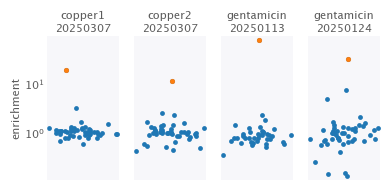

In [214]:
fig, ax, df = plot_mass_spec(df_combined, 'cpxR', filter_binding_proteins=True, highlighted_genes=['cpxR'], filter_control='839')
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
969,20.697,8,cpxR,gentamicin,839,20250113,cpxR,76.862169
1007,22.651,5,cpxR,gentamicin,839,20250124,cpxR,31.857194
516,23.274,6,cpxR,copper1,839,20250307,cpxR,18.793393
516,23.274,6,cpxR,copper2,839,20250307,cpxR,11.147950
887,11.306,4,fabR,gentamicin,839,20250124,cpxR,7.666107
586,1.438,1,narP,gentamicin,839,20250124,cpxR,4.846569
265,5.906,3,accB,copper1,839,20250307,cpxR,3.218248
101,2.494,1,nrdR,copper2,839,20250307,cpxR,2.565797
428,13.108,4,fabR,copper2,839,20250307,cpxR,2.325626
654,3.255,2,glnG,gentamicin,839,20250113,cpxR,2.298107


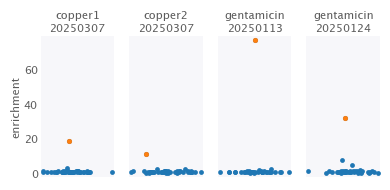

In [226]:
fig, ax, df = plot_mass_spec(df_combined, 'cpxR', filter_binding_proteins=True, highlighted_genes=['cpxR'], filter_control='839', yscale="linear")
fig.savefig("../../../figures/cpxR_mass-spec.pdf")
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
1186,23.274,6,cpxR,copper2,839,20250307,cusC,1.895025
935,5.906,3,accB,copper1,839,20250307,cusC,1.803679
1247,34.744,9,stpA,copper1,839,20250307,cusC,1.666247
1186,23.274,6,cpxR,copper1,839,20250307,cusC,1.662488
771,2.494,1,nrdR,copper2,839,20250307,cusC,1.521061
761,2.360,2,trpR,copper1,839,20250307,cusC,1.480782
691,1.036,1,yjdC,copper1,839,20250307,cusC,1.446828
800,3.028,2,yqjI,copper1,839,20250307,cusC,1.446475
790,2.822,1,kdgR,copper2,839,20250307,cusC,1.419483
722,1.635,1,narL,copper1,839,20250307,cusC,1.409582


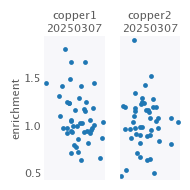

In [216]:
fig, ax, df = plot_mass_spec(df_combined, 'cusC', filter_binding_proteins=True, yscale="linear")# highlighted_genes=['cpxR'], filter_control='839')
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
3059,30.242,11,lrp,"salt, 37C",058,20240905,yjbJ,126.139879
4999,2.466,1,yhaJ,stationary,839,20241125,yjbJ,50.450311
3059,30.242,11,lrp,"stationary, 37C",058,20240905,yjbJ,39.982072
1500,110.886,15,lrp,stationary,058,20241031,yjbJ,26.063082
1500,110.886,15,lrp,"stationary, 4C",058,20241105,yjbJ,26.063082
2636,2.738,1,argR,"salt, 37C",058,20240905,yjbJ,12.959131
2551,1.543,1,yhaJ,"stationary, 37C",058,20240905,yjbJ,12.859730
1081,9.992,3,yhaJ,"stationary, 4C",058,20241105,yjbJ,8.724519
1081,9.992,3,yhaJ,stationary,058,20241031,yjbJ,8.724519
1210,18.777,3,gcvA,stationary,058,20241031,yjbJ,6.962245


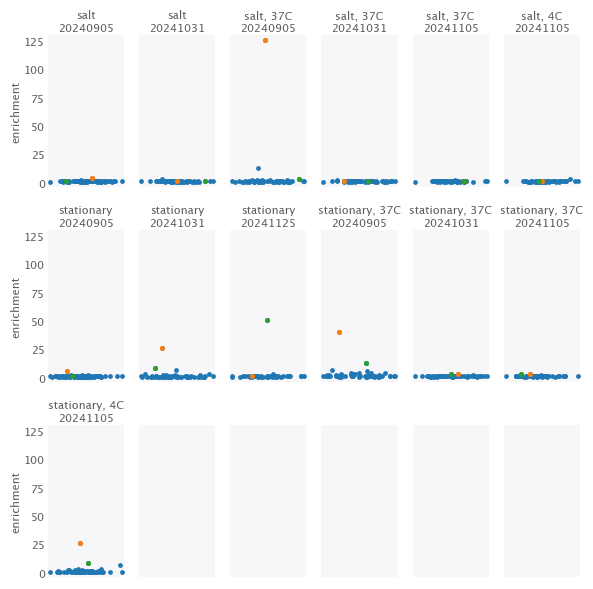

In [217]:
fig, ax, df = plot_mass_spec(df_combined, 'yjbJ', filter_binding_proteins=True, yscale="linear", filter_control=['839', '058'], highlighted_genes=['lrp', 'yhaJ'])
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
972,8.328,3,ulaR,"salt, 37C",058,20240905,yadI,32.499593
972,8.328,3,ulaR,"stationary, 37C",058,20240905,yadI,31.206910
659,13.091,5,csqR,stationary,837,20250213,yadI,29.098970
882,4.914,2,csqR,"stationary, 37C",058,20240905,yadI,19.862999
674,4.674,2,ulaR,LB2,837,20250326,yadI,19.236358
882,4.914,2,csqR,"salt, 37C",058,20240905,yadI,11.236348
1178,30.242,11,lrp,"salt, 37C",058,20240905,yadI,9.324024
3370,3.079,1,ulaR,stationary,835,20241125,yadI,8.336464
679,4.674,2,ulaR,LB1,837,20250326,yadI,7.864015
530,4.466,2,ulaR,stationary,837,20250213,yadI,7.381577


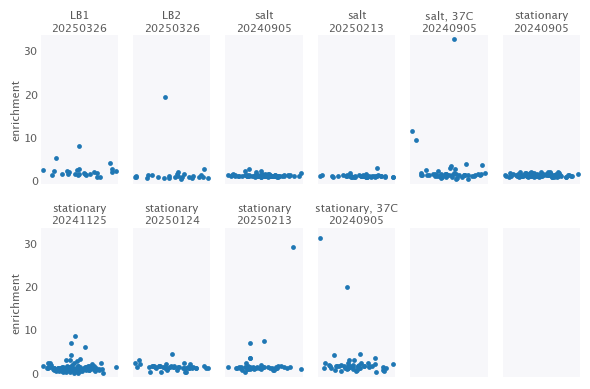

In [218]:
fig, ax, df = plot_mass_spec(df_combined, 'yadI', filter_binding_proteins=True, yscale="linear")#, filter_control=['839', '058'], highlighted_genes=['lrp', 'yhaJ'])
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
4711,7.082,2,tyrR,stationary,839,20241125,ygiW_2,44.976047
6492,5.002,3,tyrR,stationary,839,20241216,ygiW_2,22.127394
6748,31.993,10,glpR,stationary,839,20241216,ygiW_2,4.567839
6706,20.868,12,lrp,stationary,839,20241216,ygiW_2,3.151348
4906,46.998,12,glpR,stationary,839,20241125,ygiW_2,2.920084
4683,5.593,1,frlR,stationary,839,20241125,ygiW_2,2.875151
4613,3.231,2,agaR,stationary,839,20241125,ygiW_2,2.601370
6603,10.021,4,cytR,stationary,839,20241216,ygiW_2,2.383413
6574,8.820,2,argP,stationary,839,20241216,ygiW_2,2.352815
6425,3.415,1,nikR,stationary,839,20241216,ygiW_2,2.160557


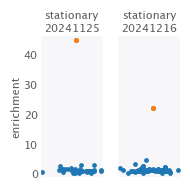

In [225]:
fig, ax, df = plot_mass_spec(df_combined, 'ygiW_2', filter_binding_proteins=True, yscale="linear", filter_control=['839'], highlighted_genes=['tyrR'])
fig.savefig("../../../figures/ygiW_2_mass-spec.pdf")
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
4099,18.759,4,yciT,glucose,839,20250213,ybiY1,105.648018
3300,19.279,7,yciT,glucose,837,20250124,ybiY1,95.786780
3248,12.508,4,glpR,glucose,837,20250124,ybiY1,15.257256
3956,6.725,2,glpR,glucose,839,20250213,ybiY1,3.355517
3035,4.810,2,fnr,glucose,837,20250124,ybiY1,3.289517
4074,14.848,6,lrp,glucose,839,20250213,ybiY1,3.241445
3295,17.956,5,deoR,glucose,837,20250124,ybiY1,3.193119
3324,25.433,8,nagC,glucose,837,20250124,ybiY1,2.925450
4123,22.252,6,glnG,glucose,839,20250213,ybiY1,2.624442
3012,4.395,3,fabR,glucose,837,20250124,ybiY1,2.442240


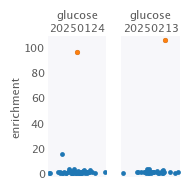

In [224]:
fig, ax, df = plot_mass_spec(df_combined, 'ybiY1', filter_binding_proteins=True, yscale="linear", highlighted_genes=['yciT'])#, filter_control=['837'], highlighted_genes=['yciT'])
fig.savefig("../../../figures/ybiY1_mass-spec.pdf")
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
1470,13.014,4,yhaJ,gentamicin,839,20250124,intE,33.451991
1352,7.998,2,yhaJ,gentamicin,839,20250113,intE,15.571426
1477,13.577,1,nadR,gentamicin,839,20250124,intE,4.790699
1186,3.255,2,glnG,gentamicin,839,20250113,intE,3.448022
1510,22.629,7,glpR,gentamicin,839,20250113,intE,3.378614
1319,5.820,1,baeR,gentamicin,839,20250124,intE,2.435948
1584,27.360,8,glpR,gentamicin,839,20250124,intE,2.309787
1561,22.841,8,crp,gentamicin,839,20250124,intE,2.227766
1069,0.867,1,dicA,gentamicin,839,20250113,intE,2.080970
1372,9.409,2,fnr,gentamicin,839,20250113,intE,1.785811


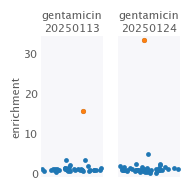

In [ ]:
fig, ax, df = plot_mass_spec(df_combined, 'intE', filter_binding_proteins=True, yscale="linear", highlighted_genes=['yhaJ'])#, filter_control=['837'], highlighted_genes=['yciT'])

fig.savefig("../../../figures/intE_mass-spec.pdf")
df.head(10)

,Sum PEP Score,# Peptides,Gene Symbol,condition,Control,date,sample,enrichment
1782,23.703,9,xynR,"stationary, 37C",058,20240905,yagB,52.626764
1304,1.603,1,fis,"salt, 37C",058,20240905,yagB,39.533248
1782,23.703,9,xynR,"salt, 37C",058,20240905,yagB,37.349865
669,61.464,11,hns,stationary,058,20241031,yagB,36.052392
669,61.464,11,hns,"stationary, 4C",058,20241105,yagB,36.052392
4064,35.123,8,xynR,stationary,837,20241125,yagB,34.194995
1805,30.242,11,lrp,"salt, 37C",058,20240905,yagB,17.800369
260,8.007,1,fis,"stationary, 4C",058,20241105,yagB,16.866846
260,8.007,1,fis,stationary,058,20241031,yagB,16.866846
1859,60.514,13,glpR,"stationary, 37C",058,20240905,yagB,15.738802


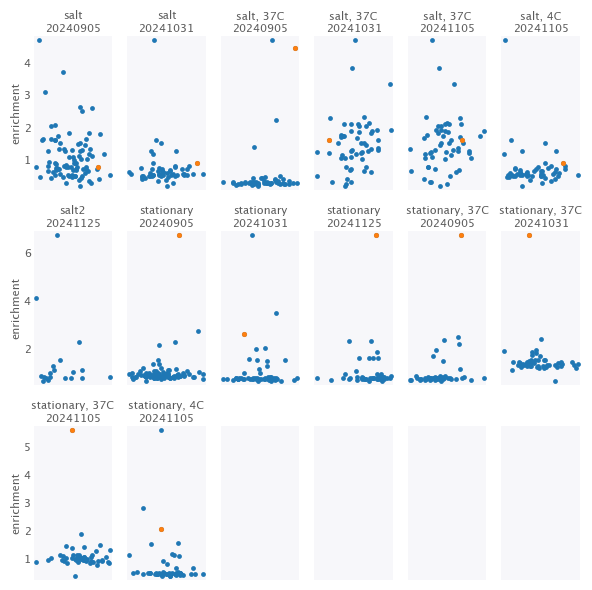

In [232]:
fig, ax, df = plot_mass_spec(df_combined, 'yagB', filter_binding_proteins=True, yscale="linear", highlighted_genes=['xynR'], filter_control=['837', '058'], sharey=False)
fig.savefig("../../../figures/yagB_mass-spec.pdf")
df.head(10)